# 2025 ASAP CRN Colloborative Meeting - CRN Cloud Training Workshop Notebook #3

## Overview
This notebook is part 3: 
- Gene of Interest (GOI) Analysis , which constitutes the bulk of the workshop's activities

## Outline 

This notebook shows how to load ASAP CRN Cloud data for the harmonized cohort of scRNAseq datasets.  (All contrubted datasets in this collection are technically single-_nucleus_ samples.)   


3. [Gene of Interest Analysis (__Workshop__)](#part-3-gene-of-interest-analysis-workshop)
    * Choose Parkinson's Disease relavent gene
    * visualize specific gene expression



## Notebooks
All of this content can be found in shorter more specific notebooks.  E.g. During the workshop you can follow along for Parts 1 & 2, but should start with Part 3 ([03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb))

- This notebook [00_full_example_notebook.ipynb](./00_full_example_notebook.ipynb)
    - Part 1 - [01_basic_EDA.ipynb](./01_basic_EDA.ipynb)  
    - Part 2 - [02_dataset_composition.ipynb](./02_dataset_composition.ipynb)
    - Part 3 - [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb)
        - Part 3-R - [03-R_GOI_analysis.ipynb](./03-R_GOI_analysis.ipynb)
    - Part 4 - [04_DE_analysis.ipynb](./04_DE_analysis.ipynb)


------------------------------
>> NOTES
>>   need to develop an equivalent R version for part 1,2, and 4

## Imports

In [1]:
import numpy as np
import pandas as pd

# Use pathlib for file path manipulation
from pathlib import Path 


# matplotlib and seaborn a pythonic alternative to plotnine
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Error -> ", e)
    print("Installing seaborn or matplotlib")
    !pip install matplotlib seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt


try:
    import scanpy as sc
except ImportError as e:
    print("Error -> ", e)
    print("Installing scanpy")
    !pip install scanpy
    import scanpy as sc

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# Always show all columns in a Pandas DataFrame
pd.set_option('display.max_columns', None)

time: 275 μs (started: 2025-02-27 10:07:38 +00:00)


###  ASAP CRN data paths
First, let's build the paths to our data. 

In [ ]:
# Workspace Path
HOME_PATH = Path.home()
WS_PATH =  HOME_PATH / 'workspace'
if not WS_PATH.exists():
    print(f"{WS_PATH} doesn't exist. We need to remount our resources")
    !wb resource mount    

time: 691 μs (started: 2025-02-27 10:07:38 +00:00)


We'll focus in on the datasets processed with our *PMDBS scRNAseq* workflow.  Specifically the _cohort_ dataset: `asap-cohort-pmdbs-sc-rnaseq`.  This dataset includes samples from 5 Contributing datasets which have been processesed and integrated.  The paths include the following parts.

- `workflow` designates the workflow which performs the aggregation and integration.  In this case the [*PMDBS scRNAseq* workflow](https://github.com/ASAP-CRN/pmdbs-sc-rnaseq-wf)
- `dataset_team` designates the contributing team for the dataset.  In this case _cohort_ designates that it is made from multiple individual contributed datasets.
- `source` designates the _source_ of the samples.  In this case Post-mortem derived Brain samples
- `dataset_type` designates the 
- `bucket_name` designates the datasets gcp bucket
- `dataset_name` designates the unique designation for each dataset or collection

In [3]:
DATASETS_PATH = WS_PATH / "01_PMDBS_scRNAseq_Datasets"
workflow = "pmdbs_sc_rnaseq"
dataset_team = "cohort"
dataset_source = "pmdbs"
dataset_type = "sc-rnaseq"
bucket_name = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_path = DATASETS_PATH / bucket_name / workflow

time: 1.24 ms (started: 2025-02-27 10:07:38 +00:00)


#### Cohort Analysis Path

Now that we've defined the path to our cohort dataset, lets list the curated files for the `cohort_analysis`.   

In [4]:
cohort_analysis_path = dataset_path / "cohort_analysis"

time: 885 μs (started: 2025-02-27 10:07:38 +00:00)


#### Dataset Metadata Path

The dataset metadata can be found in the `release_resources`.  Note that the metadata are organized by the _short_ `dataset_name` rather than `bucket_name`.  



In [ ]:
ds_metadata_path = WS_PATH / 'release_resources/asap-crn-cloud-release-resources' / dataset_name / "metadata"

!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  CONDITION.csv  PMDBS.csv     SAMPLE.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	 PROTOCOL.csv  STUDY.csv
time: 551 ms (started: 2025-02-27 10:07:38 +00:00)


#### Workshop/Notebook Artifact Path

This is the path to where the artifacts we've created in these notebooks can be found in case you want to skip ahead.  Particularly for the workshop.

In [ ]:
WORKSHOP_PATH = WS_PATH / "release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025" 

!ls {WORKSHOP_PATH}


 asap-cohort.frontal_ctx_case_control_samples.h5ad
 asap-cohort.full_frontal_ctx_case_control_samples.h5ad
 asap-cohort.full_frontal_ctx_psuedobulk_de.csv
 asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0001.csv
 asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0002.csv
 asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0004.csv
 asap-cohort.full_frontal_ctx_psuedobulk.h5ad
'GP2 European GWAS Manuscript Tables - Table 4.csv'
 workshop_ASAP_CRN_datasets_example.ipynb
 Workshop_Part1.ipynb
 Workshop_Part2.ipynb
 Workshop_Part3.ipynb
 Workshop_preamble.ipynb
 workspace_example1.png
time: 278 ms (started: 2025-02-27 10:07:39 +00:00)


#### Local Data Path
Lets also define a path for copying our data files and exporting intermediate analysis artifacts to your workspace.  In this example we'll make a "workshop_files" in the "ws_files" which are persistent in our Verily Workbench Workspace. 

In [ ]:
local_data_path = WS_PATH / "workshop_files"

if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

time: 374 ms (started: 2025-02-27 10:07:39 +00:00)


-----------------
#  Part 3: Gene of interest analysis (__Workshop__)
* Gene of interest analysis
    * Choose Parkinson's Disease relavent gene
    * Load transciptomics counts data into an anndata object
        * subset cells to subset samples from metadata
    * visualize specific gene expression

## choose your favorite genes
Now that we have a 
1. check that your gene of interest is in the current features
2. color the umap by the expression level of your gene.


We'll use the soon-to-be-published table from GP2 as a reference set of putative PD variable genes.



### Load Parkinson's reference genes.

In [ ]:
ref_gene_filename = WORKSHOP_PATH / 'GP2 European GWAS Manuscript Tables - Table 4.csv'

GP2_PD_genes = pd.read_csv(ref_gene_filename)


time: 6.36 ms (started: 2025-02-27 10:07:59 +00:00)


### Load full frontal cortex `AnnData` object for further analysis 

If you calculated these yourself in [Part 2 - 02_dataset_composition.ipynb](./02_dataset_composition.ipynb) load if from where you saved it.(e.g. 'local_data_path'). If you didn't do that, and you didn't already copy it to your 'local_data_path', it is also made it available in the `WORKSHOP_PATH`.

In [ ]:
full_frontal_samples_filename = local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"

frontal_full_ad = sc.read_h5ad(full_frontal_samples_filename)

time: 6.66 s (started: 2025-02-27 10:08:02 +00:00)


Check that we have the genes of interest.

In [13]:
pd_genes = set(GP2_PD_genes["SYMBOL"]).intersection(
    set(frontal_full_ad.var_names)
)

time: 6.73 ms (started: 2025-02-27 10:08:18 +00:00)


In [15]:
pd_genes

{'ADAM15',
 'ADD1',
 'AKT3',
 'BAG3',
 'BIRC6',
 'CAB39L',
 'CPLX1',
 'CTSB',
 'DLG2',
 'DLG4',
 'FDFT1',
 'FYN',
 'GAK',
 'GCH1',
 'ITGA2B',
 'LRRK2',
 'MAPT',
 'MED12L',
 'NCOR1',
 'P2RY12',
 'PCGF3',
 'PIK3CA',
 'RIT2',
 'SH3GL2',
 'SHC1',
 'SLC2A13',
 'SNCA',
 'STK39',
 'TMEM163',
 'TSC22D4',
 'UCHL1',
 'XPO1'}

time: 2.78 ms (started: 2025-02-27 10:08:25 +00:00)


### Choose 'query_gene' and visualize

As an example below we'll query "TSC22D4".  What gene are you interested in?

In [16]:
query_gene = "CTSB"
query_gene = "TSC22D4"


CTSB_expr = frontal_full_ad[:, query_gene].X.toarray()
cell_metadata_df = pd.DataFrame(
    CTSB_expr, columns=[query_gene], index=frontal_full_ad.obs.index
)

cell_metadata_df.loc[:, "cell_type"] = frontal_full_ad.obs["cell_type"]

cell_metadata_df.groupby("cell_type").describe()

/tmp/ipykernel_4739/3696347351.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_metadata_df.groupby("cell_type").describe()


TSC22D4                                              
              count      mean       std  min  25%  50%  75%   max
cell_type                                                        
Astro       22347.0  0.804135  1.142683  0.0  0.0  0.0  1.0  13.0
ExN        126083.0  0.050491  0.254753  0.0  0.0  0.0  0.0   9.0
InN           726.0  0.088154  0.345130  0.0  0.0  0.0  0.0   3.0
MG           8090.0  0.143263  0.413781  0.0  0.0  0.0  0.0   5.0
OPC         76552.0  0.133961  0.566849  0.0  0.0  0.0  0.0  16.0
Oligo       55627.0  0.972028  1.449174  0.0  0.0  0.0  1.0  18.0
VC           2362.0  0.230737  0.657685  0.0  0.0  0.0  0.0   8.0

time: 1.03 s (started: 2025-02-27 10:08:25 +00:00)


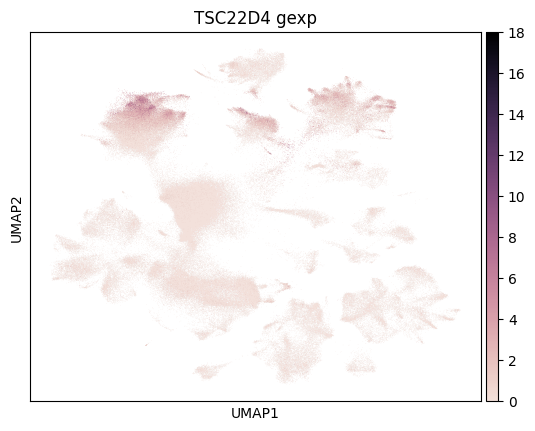

time: 2.14 s (started: 2025-02-27 10:08:26 +00:00)


In [17]:


sc.pl.embedding(
    frontal_full_ad,
    basis="umap",
    color=[query_gene],
    cmap=sns.cubehelix_palette(dark=0, light=0.9, as_cmap=True),
    title=f"{query_gene} gexp",
)

Now, what else would you like to find out from this dataset?

Some ideas:
- calculate the relative expression
- ?
- ?
- ?

-----------------
# Next:

This is the main _workshop_ notebook.  If you've exhausted what you might like to do with this dataset, continue with a differential expression analysis:

- Part 4 - Differential Expression (DE) Analysis [04_DE_analysis.ipynb](./04_DE_analysis.ipynb)


--------------------
# Provenance
Generate information about this notebook environment and the packages installed.

In [19]:
!date

Thu Feb 27 10:08:53 AM UTC 2025
time: 139 ms (started: 2025-02-27 10:08:53 +00:00)


Conda and pip installed packages:

In [26]:
!pip freeze

absl-py==2.1.0
anndata==0.11.3
annotated-types==0.7.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.10.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
awscli==1.22.34
babel==2.16.0
beautifulsoup4==4.12.3
bleach==6.2.0
blinker==1.4
botocore==1.23.34
cachetools==5.5.1
certifi==2020.6.20
cffi==1.17.1
chardet==4.0.0
charset-normalizer==3.4.1
colorama==0.4.4
comm==0.2.2
contourpy==1.3.1
cryptography==3.4.8
cycler==0.12.1
Cython==3.0.11
dbus-python==1.2.18
debugpy==1.8.12
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
docstring_parser==0.16
docutils==0.17.1
exceptiongroup==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.17.0
flatbuffers==25.1.24
fonttools==4.55.8
fqdn==1.5.1
gast==0.6.0
gitdb==4.0.12
GitPython==3.1.44
google-api-core==2.24.1
google-auth==2.38.0
google-auth-oauthlib==1.0.0
google-cloud-aiplatform==1.72.0
google-cloud-artifact-registry==1.13.1
google-cloud-bigquery==3.25.0
google-cloud-bigquery-co

JupyterLab extensions:

In [21]:
!jupyter labextension list

`sys_prefix` level settings are read-only, using `user` level for migration to `lockedExtensions`
JupyterLab v4.3.4
/home/jupyter/.local/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        jupyterlab-jupytext v1.4.3 enabled OK (python, jupytext)
        nbdime-jupyterlab v3.0.2 enabled OK
        @jupyterlab/git v0.50.2 enabled OK (python, jupyterlab-git)
        @jupyter-widgets/jupyterlab-manager v5.0.13 enabled OK (python, jupyterlab_widgets)

time: 2.73 s (started: 2025-02-27 10:08:53 +00:00)


Number of cores:

In [22]:
!grep ^processor /proc/cpuinfo | wc -l

16
time: 135 ms (started: 2025-02-27 10:08:56 +00:00)


Memory:

In [23]:
!grep "^MemTotal:" /proc/meminfo

MemTotal:       107131888 kB
time: 135 ms (started: 2025-02-27 10:09:00 +00:00)
